In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.datasets import make_regression
from patsy import dmatrix
from sklearn.linear_model import LinearRegression
import statsmodels.stats.api as sms
import numpy as np

/Users/jakekong/.pyenv/versions/3.6.1/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. Replacing NAN values if exist & Catergorization if needed

In [8]:
df = pd.read_csv("train.csv")

In [9]:
del df["AnimalID"] # 종속변수 OutcomeType과 전혀 상관 없는 변수로 구분. 사용하지 않기로 결정.
del df["DateTime"] # OutcomeType 가 발생한 시간을 나타내는 것으로 종속변수에서 파생된 변수로 구분. 사용하지 않기로 결정.
del df["OutcomeSubtype"] #OutcomeType에 대한 부분적 설명을 해주는 변수로, 결국 종속변수에 의해 영향을 받은 변수. 사용하지 않기로 결정.

# OutcomeType has 5 outcomes
- Return_to_owner
- Euthanasia
- Adoption
- Transfer
- Died
- no NAN values

# Name grouped by 'With Name' & 'Without Name'
- Names do not have regular order to be given to animals, therefore we decided to group animals by with or without

In [13]:
df_for_name = pd.read_csv("train.csv")
df_for_name["Name"] = df_for_name["Name"].replace(np.nan, 'Unknown')

def Name(x):
    if x.find('Unknown') == 0: return "Without Name"
    return "With Name"

df["Name"] = df_for_name["Name"].apply(Name)



# AnimalType has 2 types
- Dogs
- Cats
- no NAN values

# SexuponOutcome has 4 types
- Neutered Male
- Spayed Female
- Intact Male
- Intact Female
- NAN values interpreted as "Unknown"

In [24]:
df_for_sex = pd.read_csv("train.csv")
df_for_sex["SexuponOutcome"] = df_for_sex["SexuponOutcome"].replace(np.nan, 'Unknown')

df["SexuponOutcome"] = df_for_sex["SexuponOutcome"]

# AgeuponOutcome must be constructed into a varible that has types
- Replacing NAN values "Unknown"
- preprocessed into int values; age in year
- categorized into 7 divisions including the NAN values as "Unknown"

In [379]:
df_for_age = pd.read_csv('train.csv')
df_for_age["AgeuponOutcome"] = df_for_age["AgeuponOutcome"].replace(np.nan, "Unknown")

def age_by_year(x):
    if x == "Unknown": 
        return -1
    else:
        age = int(x.split(" ")[0])
        if x.find('year') >= 0: return age
        if x.find('month') >= 0: return age // 12
        if x.find('week') >= 0: return age // 52
        if x.find('day') >= 0: return age // 365
        else: return 0

def class_age(x):
    if x == -1:
        return "Unknown"
    else:
        if x <= 1: return "1 year or less"
        if 1 < x <=3: return "1-3 years"
        if 3 < x <= 5: return "3-5 years"
        if 5 < x <= 10: return "5-10 years"
        if 10 < x <=15: return "10-15 years"
        else: return "15 years or more"
        
df_for_age["AgeuponOutcome"] = df_for_age["AgeuponOutcome"].apply(age_by_year)
df_for_age["AgeuponOutcome"] = df_for_age["AgeuponOutcome"].apply(class_age)



df["AgeuponOutcome"] = df_for_age["AgeuponOutcome"]

# Color categorization
- color has 366 different types in total
- took the first mentioned color as a major color of an animal; # of color type = 29
- Division by major color: Black, Light Black,  Brown, Light Brown, White, Rare
- The Category 'Rare' includes colors that do not seem to be haircolor, or mixed by 3 or more colors
- no NAN values

In [68]:
df_for_color = pd.read_csv("train.csv")

def color(x):
    if x.find("/") >= 1 : return x.split("/")[0]
    if x.find(" ") >= 1: return x.split(" ")[0]
    else: return x

def color1(x):
    if x.find(" ") >= 1: return x.split(" ")[0]
    else: return x
    
df_for_color["Color"] = df_for_color["Color"].apply(color)
df_for_color["Color"] = df_for_color["Color"].apply(color1)


In [69]:
def color_maj(x):
    brown_color = ["Brown", "Apricot", "Buff", "Chocolate", "Red", "Orange", "Ruddy", "Liver" ]
    lig_brown_color = ["Fawn", "Gold",  "Tan", "Yellow"]
    rare_color = ["Blue", "Tricolor", "Calico", "Sable", "Pink", "Torbie", "Tortie", "Agouti"]
    black_color = ["Black", "Flame", "Seal"]
    white_color = ["White", "Cream", "Lynx"]
    lig_black_color = ["Gray", "Lilac", "Silver"]
    
    if x in brown_color: return "Brown"
    if x in lig_brown_color: return "Light Brown"
    if x in black_color: return "Black"
    if x in lig_black_color: return "Light Black"
    if x in white_color: return "White"
    if x in rare_color: return "Rare Color"
    
    
df_for_color["Color"] = df_for_color["Color"].apply(color_maj)
df["Color"] = df_for_color["Color"]

# Breed categorization
- A total of 1380 breed types
- For mixed, took the first breed type as a dominant breed; 383 breed types

In [334]:
df_for_breed = pd.read_csv("train.csv")
df_for_breed["Breed"] = df_for_breed["Breed"].replace(np.nan, "Unknown")

In [335]:
def breed_major (x):
    if x.find("Mix") >=1:
        x = list(x.split(" Mix"))
        return x[0]

    elif x.find("/") >=1:
        x= list(x.split("/"))
        return x[0]
        
    else: return x
    

df_for_breed["Breed"] = df_for_breed["Breed"].apply(breed_major)

In [339]:
def rank_dog(x):
    dog_ten = ['Labrador Retriever', 'German Shepherd', 'Golden Retriever', \
            'Bulldog', 'Beagle', 'French Bulldog', 'Poodle', 'Rottweiler', 'Yorkshire Terrier', 'Boxer']
    dog_twenty = ['German Shorthair Pointer', 'Siberian Husky', 'Dachshund', 'Great Dane',\
             'Doberman Pinscher', 'Australian Shepherd', 'Miniature Schnauzer', 'Pembroke Welsh Corgi'\
             'Cavalier Span', 'Shih Tzu']
    dog_rest = ['Shetland Sheepdog', 'Pit Bull', 'Lhasa Apso',
       'Cairn Terrier', 'American Pit Bull Terrier',
       'Great Pyrenees', 'Angora', 'Flat Coat Retriever',
       'Queensland Heeler', 'Plott Hound',
       'American Staffordshire Terrier', 'Chihuahua Shorthair',
       'Russian Blue', 'Collie Smooth', 'Domestic Longhair', 'Blue Lacy',
       'Black Mouth Cur', 'Maltese', 'Pointer', 'English Foxhound',
       'Vizsla', 'Cardigan Welsh Corgi', 'Chow Chow',
       'Domestic Medium Hair', 'Border Collie', 'Border Terrier',
       'Dogo Argentino', 'Tibetan Terrier', 'Miniature Pinscher',
       'Rat Terrier', 'Dachshund Longhair', 'Australian Cattle Dog',
       'Catahoula', 'Miniature Poodle', 'Jack Russell Terrier',
       'Doberman Pinsch', 'Whippet', 'English Pointer', 'Chesa Bay Retr',
       'Basset Hound', 'Airedale Terrier', 'Manx', 'Cocker Spaniel',
       'Chihuahua Longhair', 'Anatol Shepherd', 'Chinese Sharpei', 'Akita',
       'American Bulldog', 'Bernese Mountain Dog', 'English Bulldog',
       'Dachshund Wirehair', 'Black/Tan Hound', 'Norfolk Terrier',
       'Scottish Terrier', 'Devon Rex', 'Treeing Walker Coonhound',
       'Rhod Ridgeback', 'Snowshoe', 'Harrier', 'Australian Kelpie',
       'Mexican Hairless', 'Redbone Hound', 'Afghan Hound',
       'Swedish Vallhund', 'Papillon', 'West Highland', 'Shiba Inu',
       'Beauceron', 'Pekingese', 'Schipperke', 'Burmese', 'Collie Rough',
       'Staffordshire', 'Silky Terrier', 'Bruss Griffon', 'Pug',
       'Boerboel', 'Bengal', 'Bichon Frise', 'Manchester Terrier',
       'English Setter', 'Pomeranian', 'Greater Swiss Mountain Dog',
       'American Shorthair', 'Bull Terrier', 'Pembroke Welsh Corgi',
       'Toy Poodle', 'Bullmastiff', 'Smooth Fox Terrier',
       'Old English Bulldog', 'Ibizan Hound', 'Boston Terrier', 'Brittany',
       'Newfoundland', 'Parson Russell Terrier', 'Carolina Dog', 'Mastiff',
       'St. Bernard Rough Coat', 'Basenji', 'Bloodhound', 'Affenpinscher',
       'Himalayan', 'Norwich Terrier', 'Greyhound', 'Boykin Span',
       'Weimaraner', 'Skye Terrier', 'Schnauzer Giant', 'Alaskan Husky',
       'Belgian Malinois', 'American Eskimo', 'Italian Greyhound',
       'Irish Wolfhound', 'Wire Hair Fox Terrier', 'Landseer', 'Bombay',
       'St. Bernard Smooth Coat', 'Standard Schnauzer',
       'English Springer Spaniel', 'Alaskan Malamute', 'Cavalier Span',
       'Soft Coated Wheaten Terrier', 'Kuvasz', 'American Foxhound',
       'Podengo Pequeno', 'Leonberger', 'English Shepherd', 'Cornish Rex',
       'Standard Poodle', 'Dutch Shepherd', 'Dalmatian', 'Balinese',
       'English Coonhound', 'Old English Sheepdog', 'Jindo',
       'Welsh Terrier', 'Javanese', 'Finnish Spitz', 'Field Spaniel',
       'Keeshond', 'Irish Setter', 'Picardy Sheepdog', 'Patterdale Terr',
       'German Wirehaired Pointer', 'Havanese', 'Unknown', 'Black',
       'Pharaoh Hound', 'Bearded Collie', 'Toy Fox Terrier', 'Canaan Dog',
       'Irish Terrier', 'Treeing Tennesse Brindle', 'Japanese Bobtail',
       'Tibetan Spaniel', 'Cane Corso', 'Pbgv', 'Glen Of Imaal',
       'Australian Terrier', 'Pixiebob Shorthair', 'Presa Canario',
       'Chinese Crested', 'Neapolitan Mastiff', 'Bedlington Terr',
       'Nova Scotia Duck Tolling Retriever', 'Wirehaired Pointing Griffon',
       'Feist', 'Belgian Sheepdog', 'Samoyed', 'Otterhound', 'Tonkinese',
       'Welsh Springer Spaniel', 'Entlebucher', 'Bull Terrier Miniature',
       'Dogue De Bordeaux', 'Bluetick Hound', 'Ocicat', 'Sealyham Terr',
       'Munchkin Longhair', 'Japanese Chin', 'Saluki', 'Turkish Van',
       'Hovawart', 'Norwegian Elkhound', 'Norwegian Forest Cat', 'Cymric',
       'German Pinscher', 'Port Water Dog', 'Treeing Cur',
       'Belgian Tervuren', 'Spanish Mastiff', 'Lowchen', 'Havana Brown',
       'Swiss Hound', 'English Cocker Spaniel', 'Spinone Italiano']
    cat_ten = ['Exotic Shorthair', 'Persian', 'Maine Coon', 'Ragdoll', 'British Shorthair',
          'Domestic Shorthair', 'Abyssinian', 'Sphynx', 'Siamese']
    cat_rest = ['Domestic Shorthair', 'Angora', 'Russian Blue', 'Domestic Longhair',
       'Siamese', 'Domestic Medium Hair', 'Manx', 'Exotic Shorthair',
       'Devon Rex', 'Snowshoe', 'Maine Coon', 'Burmese', 'Bengal',
       'American Shorthair', 'Himalayan', 'Ragdoll', 'Bombay', 'Persian',
       'Cornish Rex', 'Balinese', 'Javanese', 'British Shorthair',
       'Japanese Bobtail', 'Pixiebob Shorthair', 'Tonkinese', 'Sphynx',
       'Ocicat', 'Abyssinian', 'Munchkin Longhair', 'Turkish Van',
       'Norwegian Forest Cat', 'Cymric', 'Havana Brown']
    for i in range(10):
        if x in dog_ten: return "Top 10 Dogs"
        elif x in dog_twenty: return "Top 20 Dogs"
        elif x in dog_rest: return "Not popular Dogs"
        elif x in cat_ten: return "Top 10 Cats"
        elif x in cat_rest: return "Not popular Cats"
        else: return x
    
df_for_breed["Breed"] = df_for_breed["Breed"].apply(rank_dog)
df["Breed"] = df_for_breed["Breed"]

# Graph visualization ( OutcomeType vs independent variables)

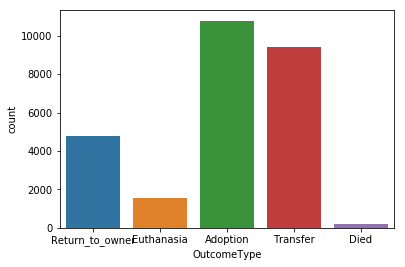

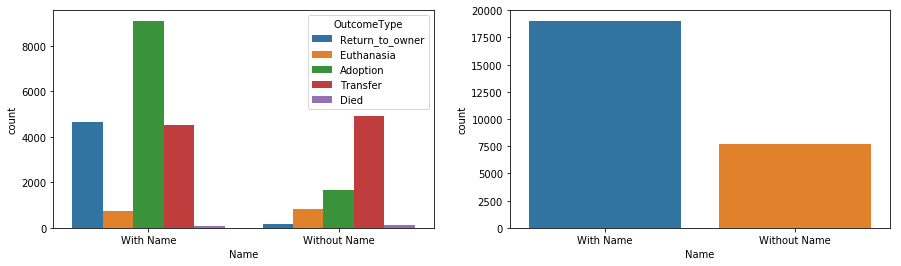

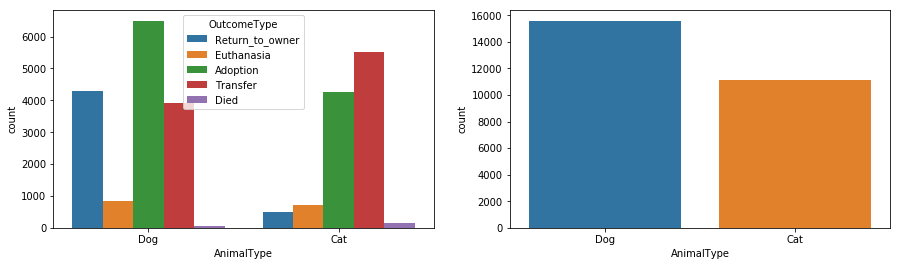

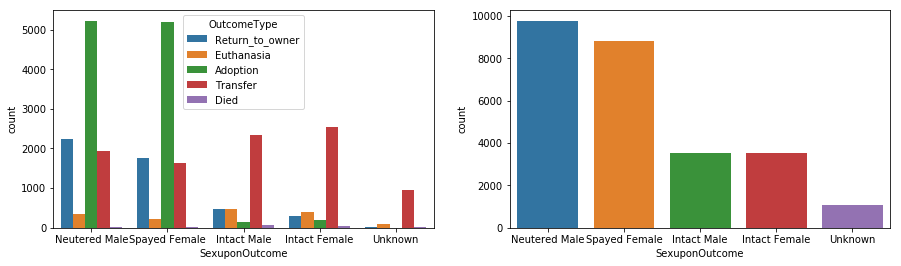

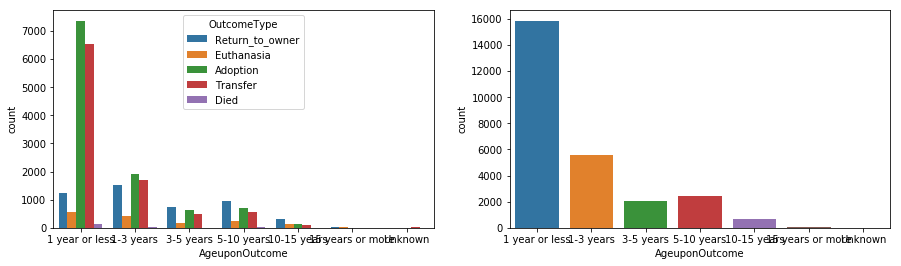

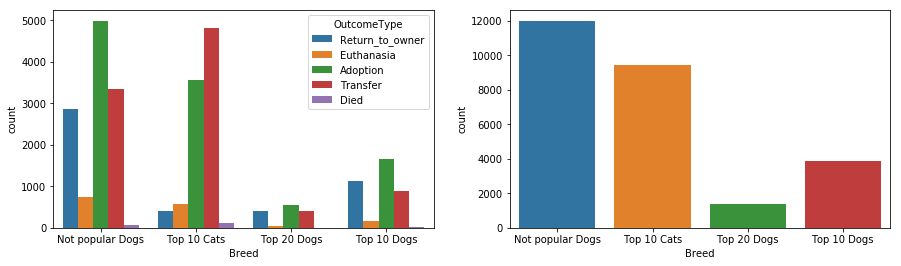

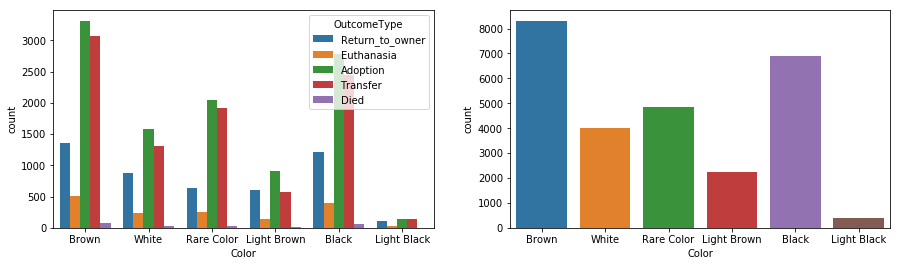

In [352]:
sns.countplot(df.OutcomeType)
plt.show()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(df.Name, hue = df.OutcomeType, ax=ax1)
sns.countplot(df.Name, ax=ax2)
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(df.AnimalType, hue = df.OutcomeType, ax=ax1)
sns.countplot(df.AnimalType, ax=ax2)
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(df.SexuponOutcome, hue = df.OutcomeType, ax=ax1)
sns.countplot(df.SexuponOutcome, ax=ax2)
plt.show()
              
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(df.AgeuponOutcome, hue = df.OutcomeType, ax=ax1)
sns.countplot(df.AgeuponOutcome, ax=ax2)
plt.show()
              
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(df.Breed, hue = df.OutcomeType, ax=ax1)
sns.countplot(df.Breed, ax=ax2)
plt.show()
              
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(df.Color, hue = df.OutcomeType, ax=ax1)
sns.countplot(df.Color, ax=ax2)
plt.show()


# Encoding by LabelEncoder

In [380]:
from sklearn.preprocessing import LabelEncoder

features = ["Name","OutcomeType","AnimalType","SexuponOutcome","AgeuponOutcome","Breed","Color"]

for i in features:
    le = LabelEncoder()
    le.fit(df[i])
    df[i] = le.transform(df[i])

# RandomForest: Feature Importance

In [376]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
X = ["Name", "AnimalType","SexuponOutcome","AgeuponOutcome","Breed","Color"]
x = df[X]
y = df["OutcomeType"]

forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(x, y)

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(x.shape[1]):
     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 2 (0.476123)
2. feature 0 (0.231567)
3. feature 3 (0.145118)
4. feature 1 (0.098104)
5. feature 5 (0.026154)
6. feature 4 (0.022934)


In [377]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

cross_val_score(forest, x, y, cv=KFold(10, shuffle=True), scoring = "accuracy")

array([ 0.62364385,  0.6255144 ,  0.63860831,  0.6318743 ,  0.62177329,
        0.63112608,  0.63262252,  0.63150019,  0.63898242,  0.60516467])

In [378]:
from sklearn.metrics import log_loss, accuracy_score


forest = ExtraTreesClassifier(n_estimators=5)

# model = LinearRegression()
cv = KFold(5)

scores = np.zeros(5)
for i, (train_index, test_index) in enumerate(cv.split(x)):
    x_train = x.iloc[train_index]
    y_train = y.iloc[train_index]
    x_test = x.iloc[test_index]
    y_test = y.iloc[test_index]
    forest.fit(x_train, y_train) 
    #    model.fit(X_train, y_train)
    #y_pred = forest.predict_proba(X_test)
    y_pred = forest.predict_proba(x_test)
    #scores[i] = log_loss(y_test, y_pred)
    
    scores[i] = log_loss(y_test, y_pred)

scores

array([ 1.29750305,  1.26031516,  1.31490629,  1.41744154,  1.24037426])